# Detect disturbed tress

## Packages and Data

In [33]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [34]:
import pandas as pd
import numpy as np
from utils.constants import spectral_bands, indices
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from utils.data_loader import DataLoader
from utils.calculate_indices import CalculateIndices
from scipy.stats import pointbiserialr
from utils.preprocessing import Preprocessing
from scipy.stats import linregress

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
dataloader = DataLoader()
df_base = dataloader.load_transform("../../data/Trainings_Datensatz.csv")
df = dataloader.date_feature_extraction(df_base)
df = dataloader.feature_extraction(df)

df = Preprocessing.interpolate_b4(df, method="linear")

In [36]:
calculateindices = CalculateIndices()
df = calculateindices.add_all_indices(df)

## Calculate stdv deviation for every index column

1. Normalize columns so that those with higher ranges do not have a greater influence
2. Group by year and compute the mean of each index column
3. Compute the standard deviation of the yearly values
4. Join column "is_disturbed" to the resulting df

In [37]:
bands_and_indices = spectral_bands + indices

scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[bands_and_indices] = df.groupby("species")[bands_and_indices].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
) 
# normalization grouped by species because different species can have different ranges 

In [38]:
df_yearly = df_norm.groupby(["id", "year"])[bands_and_indices].mean().reset_index()
stdv_df = df_yearly.groupby("id")[bands_and_indices].std().reset_index()
stdv_df = stdv_df.rename(columns={col: f"{col}_stdv" for col in bands_and_indices})

df_disturbance = df.groupby("id")["is_disturbed"].first().reset_index()
stdv_df = stdv_df.merge(df_disturbance, on="id", how="left")

In [39]:
stdv_df

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,...,gndvi_stdv,wdvi_stdv,tndvi_stdv,savi_stdv,ipvi_stdv,mcari_stdv,reip_stdv,masvi2_stdv,dvi_stdv,is_disturbed
0,1,0.001443,0.002388,0.002022,0.002207,0.006962,0.008983,0.008581,0.008661,0.002837,...,0.004492,0.008265,0.003255,0.005164,0.005050,0.000174,0.000159,0.000059,0.007326,False
1,2,0.002638,0.004479,0.003646,0.004730,0.005678,0.007194,0.005216,0.007551,0.009846,...,0.011259,0.006677,0.010242,0.012420,0.012423,0.000398,0.000155,0.002494,0.005223,False
2,3,0.005808,0.007473,0.011374,0.013846,0.022905,0.024976,0.027478,0.027717,0.030973,...,0.029003,0.044712,0.041316,0.055254,0.055209,0.002571,0.000085,0.000064,0.048469,True
3,4,0.003046,0.007629,0.008592,0.011366,0.018492,0.020920,0.023722,0.021066,0.015042,...,0.009050,0.028927,0.014787,0.018295,0.018311,0.000663,0.000142,0.009052,0.018591,False
4,5,0.002885,0.004692,0.006805,0.007227,0.017081,0.017616,0.018928,0.017664,0.008911,...,0.019241,0.033850,0.023179,0.030034,0.030002,0.002147,0.000067,0.000033,0.039482,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28207,28208,0.002490,0.003957,0.005900,0.007598,0.009079,0.008313,0.008750,0.010352,0.010685,...,0.016005,0.015582,0.021057,0.025953,0.025927,0.001103,0.000076,0.000054,0.019025,False
28208,28209,0.007227,0.008205,0.013705,0.016075,0.012198,0.015518,0.014618,0.015827,0.043116,...,0.068358,0.026903,0.064027,0.089236,0.089233,0.001054,0.000701,0.006053,0.034537,True
28209,28210,0.001678,0.001161,0.003130,0.001578,0.004340,0.006149,0.006252,0.006839,0.005941,...,0.007609,0.011202,0.010657,0.014393,0.014378,0.000768,0.000047,0.000012,0.013326,False
28210,28211,0.002685,0.002356,0.004028,0.002783,0.006951,0.010522,0.009819,0.008603,0.012807,...,0.028686,0.014378,0.019028,0.030101,0.030090,0.001399,0.000487,0.001300,0.019665,False


## Calculate slope of yearly mean

In [40]:
# slope_list_all = None

# for col in bands_and_indices:
#     slopes_per_feature = []
#     for id_ in df_yearly["id"].unique():
#         df_sub = df_yearly[df_yearly["id"] == id_]
#         slope, intercept, r_value, p_value, std_err = linregress(df_sub["year"], df_sub[col])
#         slopes_per_feature.append({"id": id_, f"{col}_slope": slope})
    
#     slope_df = pd.DataFrame(slopes_per_feature)
#     if slope_list_all is None:
#         slope_list_all = slope_df
#     else:
#         slope_list_all = slope_list_all.merge(slope_df, on="id")

In [41]:
# stdv_slope_df = stdv_df.merge(slope_list_all, on="id", how="left")

## Calculate diff of start and end value

In [42]:
# diff_list_all = None

# for col in bands_and_indices:
#     diffs_per_feature = []
#     for id_, group in df_yearly.groupby("id"):
#         group_sorted = group.sort_values("year")

#         first_years = group_sorted[col].head(2).mean()
#         last_year = group_sorted[col].tail(1).mean()
        
#         diff = last_year - first_years
#         diffs_per_feature.append({"id": id_, f"{col}_diff": diff})
    
#     diff_df = pd.DataFrame(diffs_per_feature)
    
#     if diff_list_all is None:
#         diff_list_all = diff_df
#     else:
#         diff_list_all = diff_list_all.merge(diff_df, on="id")

In [43]:
# stdv_slope_diff_df = stdv_slope_df.merge(diff_list_all, on="id", how="left")

In [44]:
stdv_slope_diff_df = pd.read_csv("../../data/stdv_slope_diff_per_id.csv")
stdv_slope_diff_df

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,...,ndvi_diff,gndvi_diff,wdvi_diff,tndvi_diff,savi_diff,ipvi_diff,mcari_diff,reip_diff,masvi2_diff,dvi_diff
0,1,0.001443,0.002388,0.002022,0.002207,0.006962,0.008983,0.008581,0.008661,0.002837,...,-0.004651,-0.009385,-0.006631,-0.002755,-0.004772,-0.004651,-0.000247,-0.000085,1.195572e-04,-0.005735
1,2,0.002638,0.004479,0.003646,0.004730,0.005678,0.007194,0.005216,0.007551,0.009846,...,-0.005498,-0.003018,0.016898,-0.004176,-0.005490,-0.005498,-0.000099,-0.000048,-5.817541e-03,0.011288
2,3,0.005808,0.007473,0.011374,0.013846,0.022905,0.024976,0.027478,0.027717,0.030973,...,-0.050241,-0.034676,0.052316,-0.040042,-0.050262,-0.050241,0.002800,-0.000095,-9.562703e-05,0.047605
3,4,0.003046,0.007629,0.008592,0.011366,0.018492,0.020920,0.023722,0.021066,0.015042,...,-0.025816,-0.005400,0.054306,-0.020280,-0.025788,-0.025816,-0.000036,-0.000038,-1.565950e-02,0.036029
4,5,0.002885,0.004692,0.006805,0.007227,0.017081,0.017616,0.018928,0.017664,0.008911,...,-0.010974,0.011352,-0.044305,-0.005118,-0.010990,-0.010974,-0.005169,0.000087,2.337725e-05,-0.046506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28207,28208,0.002490,0.003957,0.005900,0.007598,0.009079,0.008313,0.008750,0.010352,0.010685,...,-0.005587,-0.004416,0.001742,-0.001960,-0.005591,-0.005587,0.000288,-0.000100,-7.422282e-05,-0.007561
28208,28209,0.007227,0.008205,0.013705,0.016075,0.012198,0.015518,0.014618,0.015827,0.043116,...,-0.191461,-0.137982,-0.022847,-0.137687,-0.191458,-0.191461,-0.001868,-0.001353,3.137619e-03,-0.050564
28209,28210,0.001678,0.001161,0.003130,0.001578,0.004340,0.006149,0.006252,0.006839,0.005941,...,-0.014826,-0.007190,0.001863,-0.011716,-0.014839,-0.014826,-0.000386,0.000024,-2.630120e-07,-0.000502
28210,28211,0.002685,0.002356,0.004028,0.002783,0.006951,0.010522,0.009819,0.008603,0.012807,...,-0.033772,-0.036068,-0.010189,-0.020963,-0.033780,-0.033772,-0.001224,-0.000883,8.438026e-04,-0.014962


## Correlation between features and disturbance

In [45]:
correlations = []

for col in [c for c in stdv_slope_diff_df.columns if c.endswith("_stdv") or c.endswith("_slope") or c.endswith("_diff")]:
    r, p = pointbiserialr(stdv_slope_diff_df["is_disturbed"].astype(int), stdv_slope_diff_df[col])
    correlations.append({"feature": col, "correlation": r, "p_value": p})

correlations = pd.DataFrame(correlations).sort_values(by="correlation", ascending=False)

correlations

,feature,correlation,p_value
28,b11_slope,0.531285,0.000000e+00
23,b5_slope,0.528492,0.000000e+00
8,b11_stdv,0.517996,0.000000e+00
11,gndvi_stdv,0.514982,0.000000e+00
3,b5_stdv,0.501880,0.000000e+00
20,b2_slope,0.492893,0.000000e+00
43,b5_diff,0.488226,0.000000e+00
15,ipvi_stdv,0.487777,0.000000e+00
10,ndvi_stdv,0.487777,0.000000e+00
14,savi_stdv,0.486328,0.000000e+00


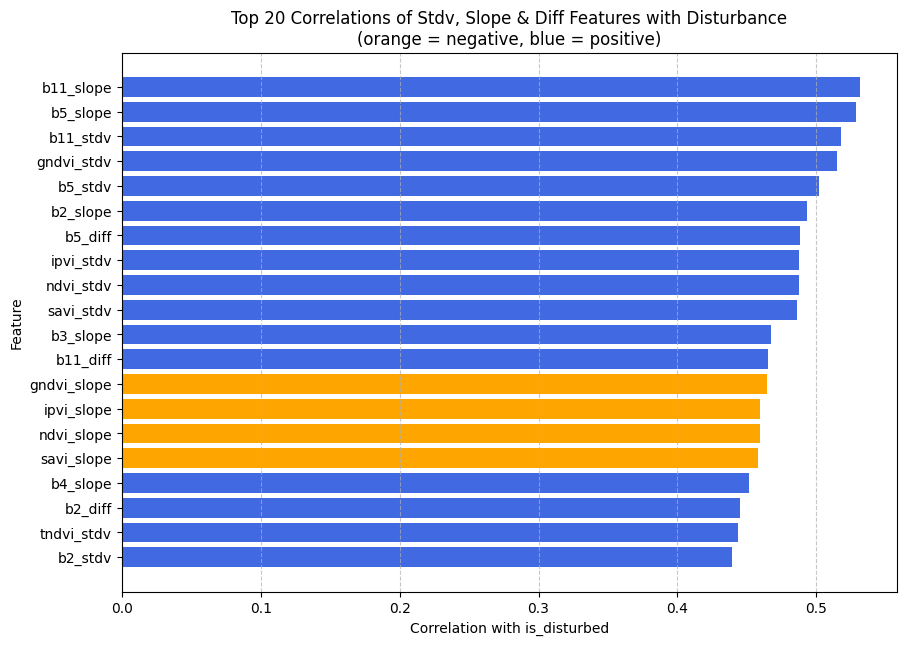

In [120]:
correlations["abs_corr"] = correlations["correlation"].abs()

correlations_df_to_plot = correlations.sort_values(by="abs_corr", ascending=True).tail(20)
colors = ["orange" if val < 0 else "royalblue" for val in correlations_df_to_plot["correlation"]]

plt.figure(figsize=(10, 7))
plt.barh(
    correlations_df_to_plot["feature"],
    correlations_df_to_plot["abs_corr"],
    color=colors
)

plt.xlabel("Correlation with is_disturbed")
plt.ylabel("Feature")
plt.title("Top 20 Correlations of Stdv, Slope & Diff Features with Disturbance\n(orange = negative, blue = positive)")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

## Analysis stdv, slope & diff of indices 

In [47]:
col = "b11"
slope_or_stdv = "slope"
stdv_slope_diff_df[~stdv_slope_diff_df["is_disturbed"]].sort_values(f"{col}_{slope_or_stdv}", ascending=False)

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,...,ndvi_diff,gndvi_diff,wdvi_diff,tndvi_diff,savi_diff,ipvi_diff,mcari_diff,reip_diff,masvi2_diff,dvi_diff
11875,11876,0.015522,0.023574,0.049952,0.041534,0.007538,0.014239,0.011697,0.007032,0.107883,...,-0.324991,-0.128959,-0.077927,-0.277194,-0.324969,-0.324991,-0.001542,0.000047,0.001743,-0.115229
4605,4606,0.015251,0.018310,0.029489,0.027501,0.019603,0.019750,0.023394,0.020305,0.113322,...,-0.214669,-0.156624,0.041912,-0.147256,-0.214620,-0.214669,-0.001181,-0.001382,-0.007265,0.019520
26201,26202,0.013934,0.016201,0.027229,0.025218,0.014909,0.014042,0.016933,0.016095,0.109507,...,-0.207304,-0.149813,0.032107,-0.139968,-0.207223,-0.207304,-0.001641,-0.001918,-0.008741,0.013195
6176,6177,0.013941,0.016781,0.026801,0.025058,0.017302,0.016253,0.019201,0.018143,0.107465,...,-0.218062,-0.165039,0.039738,-0.147240,-0.218001,-0.218062,-0.001046,-0.001848,-0.007410,0.020800
509,510,0.015252,0.017624,0.029553,0.025671,0.017702,0.016185,0.018851,0.017604,0.108101,...,-0.236334,-0.173603,0.037778,-0.160397,-0.236278,-0.236334,-0.002015,-0.001179,-0.007132,0.015360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19972,19973,0.004048,0.009329,0.012597,0.016100,0.031562,0.034840,0.043284,0.037841,0.032613,...,0.056347,0.039467,0.011180,0.047286,0.056353,0.056347,-0.000462,0.001241,-0.007789,0.016942
22319,22320,0.012512,0.014623,0.011250,0.016384,0.033185,0.037978,0.041252,0.037826,0.042537,...,0.011598,0.025977,-0.063246,0.007815,0.011592,0.011598,-0.002582,0.000290,0.000898,-0.070560
14016,14017,0.031947,0.048587,0.061931,0.059145,0.054104,0.051903,0.054228,0.049897,0.048233,...,0.069388,0.067401,-0.083020,0.064307,0.069452,0.069388,0.001557,-0.000259,0.000199,-0.000491
17513,17514,0.121576,0.119378,0.118368,0.117796,0.107294,0.103265,0.104693,0.099919,0.103603,...,0.056329,0.070051,-0.152263,0.048736,0.056387,0.056329,0.000569,-0.000032,0.000060,0.012431


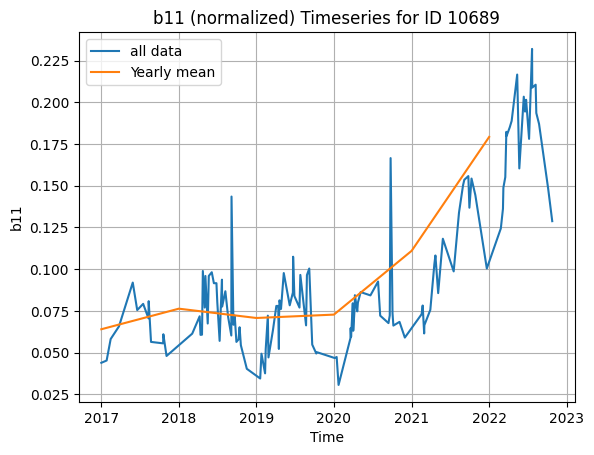

In [48]:
def plot_timeseries_oneid(id, col, yearly_mean = True):

    df_sub = df_norm[df_norm["id"] == id]

    plt.plot(df_sub["time"], df_sub[col], label="all data")

    if yearly_mean: 
        df_yearly_sub = df_yearly[df_yearly["id"] == id].copy()
        df_yearly_sub["year_dt"] = pd.to_datetime(df_yearly_sub["year"].astype(str) + "-01-01")
        plt.plot(df_yearly_sub["year_dt"], df_yearly_sub[col], label="Yearly mean")

    plt.title(f"{col} (normalized) Timeseries for ID {id}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_timeseries_oneid(10689, col)

## Model to detect mislabeled trees

### Build training data from data with presumably correctly labeled data

In [49]:
disturbed_df = stdv_slope_diff_df[stdv_slope_diff_df["is_disturbed"]].copy()
healthy_df = stdv_slope_diff_df[~stdv_slope_diff_df["is_disturbed"]].copy()

In [50]:
top_features = ["b11_slope", "b5_slope", "b11_stdv", "gndvi_stdv"]
healthy_df["combi_top_features"] = healthy_df[top_features].mean(axis=1)
healthy_df.sort_values(by="combi_top_features")

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,...,gndvi_diff,wdvi_diff,tndvi_diff,savi_diff,ipvi_diff,mcari_diff,reip_diff,masvi2_diff,dvi_diff,combi_top_features
12043,12044,0.003088,0.003261,0.007149,0.005418,0.006134,0.006345,0.007030,0.005714,0.003331,...,-0.000299,-0.015612,0.019195,0.021375,0.021360,0.000574,-0.000118,1.117116e-04,-0.003839,0.000652
10951,10952,0.022716,0.022592,0.024803,0.019423,0.016529,0.015527,0.019662,0.016593,0.011202,...,0.004491,-0.037935,-0.003433,-0.003140,-0.003136,0.001132,0.001762,3.325936e-05,-0.002958,0.000733
15155,15156,0.000397,0.001539,0.000668,0.001931,0.006208,0.007066,0.006467,0.007664,0.001977,...,0.005851,-0.008132,-0.005616,-0.008510,-0.008324,-0.000769,0.000368,4.485918e-05,-0.007719,0.000735
23144,23145,0.000601,0.000953,0.000389,0.000911,0.002480,0.002882,0.002695,0.003387,0.000899,...,0.003262,0.000876,0.002389,0.003727,0.003649,-0.000146,-0.000011,-1.259024e-07,0.001067,0.000760
17446,17447,0.002315,0.002662,0.002019,0.001949,0.003682,0.003114,0.003856,0.003112,0.000826,...,-0.004276,-0.007790,-0.012357,-0.012898,-0.012886,-0.000188,0.000266,6.482195e-05,-0.006998,0.000821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24990,24991,0.014754,0.017541,0.028682,0.025342,0.017278,0.016097,0.018597,0.017729,0.106960,...,-0.176000,0.038184,-0.157136,-0.232065,-0.232122,-0.002026,-0.000901,-7.114118e-03,0.016530,0.062107
11875,11876,0.015522,0.023574,0.049952,0.041534,0.007538,0.014239,0.011697,0.007032,0.107883,...,-0.128959,-0.077927,-0.277194,-0.324969,-0.324991,-0.001542,0.000047,1.742990e-03,-0.115229,0.062299
509,510,0.015252,0.017624,0.029553,0.025671,0.017702,0.016185,0.018851,0.017604,0.108101,...,-0.173603,0.037778,-0.160397,-0.236278,-0.236334,-0.002015,-0.001179,-7.131621e-03,0.015360,0.062560
4605,4606,0.015251,0.018310,0.029489,0.027501,0.019603,0.019750,0.023394,0.020305,0.113322,...,-0.156624,0.041912,-0.147256,-0.214620,-0.214669,-0.001181,-0.001382,-7.264696e-03,0.019520,0.062853


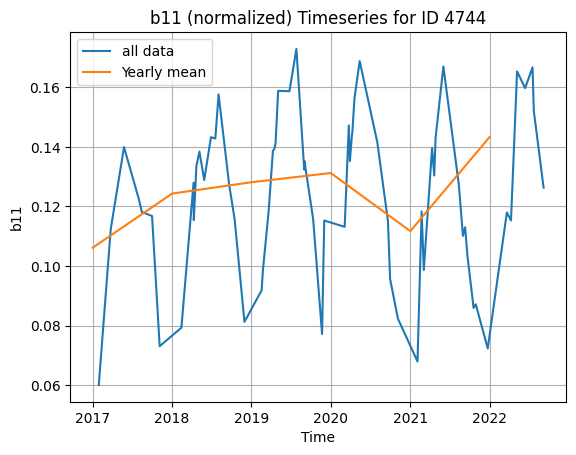

In [51]:
plot_timeseries_oneid(4744 , col)

- Idea: Healthy df with 10,000 data points that are almost certainly not disturbed
- the four top features must have a low value

- Testing of random samples showed that the first 20,000 rows of healthy_df should not be disturbed trees.

In [52]:
healthy_df_sub = healthy_df.sort_values(by="combi_top_features").head(20000).sample(n=10000, random_state=42)

train_df = pd.concat([disturbed_df, healthy_df_sub]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Disturbed:", len(disturbed_df))
print("Healthy (balanced):", len(healthy_df_sub))
print("Training set total:", len(train_df))

Disturbed: 3630
Healthy (balanced): 10000
Training set total: 13630


### Train ML-Models to predict disturbance  

In [121]:
feature_cols = [c for c in train_df.columns if c.endswith("_stdv") or c.endswith("_slope")]

X = train_df[feature_cols]
y = train_df["is_disturbed"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# model result was better without diff columns

In [124]:
# model = RandomForestClassifier(n_estimators=200, random_state=42)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)[:, 1]

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))


In [125]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# xgboost has better result than random forest classifier

Confusion Matrix:
[[2986   14]
 [  71 1018]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3000
           1       0.99      0.93      0.96      1089

    accuracy                           0.98      4089
   macro avg       0.98      0.97      0.97      4089
weighted avg       0.98      0.98      0.98      4089



### Apply model to detect mislabeled trees

In [126]:
X_healthy= healthy_df[feature_cols]
healthy_df["is_disturbed_pred"] = xgb_model.predict(X_healthy)

In [127]:
print(len(healthy_df[healthy_df["is_disturbed_pred"]==0]))
print(len(healthy_df[healthy_df["is_disturbed_pred"]==1]))

22105
2477


In [128]:
healthy_df[healthy_df["is_disturbed_pred"]==1].sort_values(by="combi_top_features")

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,...,wdvi_diff,tndvi_diff,savi_diff,ipvi_diff,mcari_diff,reip_diff,masvi2_diff,dvi_diff,combi_top_features,is_disturbed_pred
16105,16106,0.000763,0.000577,0.001364,0.002611,0.006615,0.008244,0.010810,0.009351,0.004197,...,0.013698,0.011621,0.012606,0.012604,-0.000357,-0.000006,-0.003116,0.011888,0.002608,1
9006,9007,0.001515,0.000816,0.001558,0.000949,0.002712,0.003339,0.003615,0.003698,0.002195,...,-0.009162,-0.006259,-0.009910,-0.009895,-0.000864,0.000072,0.001567,-0.011692,0.003010,1
15616,15617,0.001897,0.001244,0.001740,0.001344,0.004219,0.005245,0.004174,0.004859,0.003326,...,0.003429,0.008668,0.013617,0.013620,0.003289,-0.000002,-0.000111,0.004935,0.003245,1
8318,8319,0.002081,0.002030,0.004014,0.003758,0.005599,0.006749,0.005798,0.007140,0.005541,...,-0.007999,-0.017493,-0.022844,-0.022843,-0.001874,0.000023,0.002834,-0.008570,0.003338,1
27263,27264,0.001285,0.001489,0.001409,0.001047,0.002431,0.002103,0.002672,0.001979,0.003326,...,0.004245,0.013687,0.020845,0.020835,0.000165,0.000340,-0.001257,0.006667,0.003635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24990,24991,0.014754,0.017541,0.028682,0.025342,0.017278,0.016097,0.018597,0.017729,0.106960,...,0.038184,-0.157136,-0.232065,-0.232122,-0.002026,-0.000901,-0.007114,0.016530,0.062107,1
11875,11876,0.015522,0.023574,0.049952,0.041534,0.007538,0.014239,0.011697,0.007032,0.107883,...,-0.077927,-0.277194,-0.324969,-0.324991,-0.001542,0.000047,0.001743,-0.115229,0.062299,1
509,510,0.015252,0.017624,0.029553,0.025671,0.017702,0.016185,0.018851,0.017604,0.108101,...,0.037778,-0.160397,-0.236278,-0.236334,-0.002015,-0.001179,-0.007132,0.015360,0.062560,1
4605,4606,0.015251,0.018310,0.029489,0.027501,0.019603,0.019750,0.023394,0.020305,0.113322,...,0.041912,-0.147256,-0.214620,-0.214669,-0.001181,-0.001382,-0.007265,0.019520,0.062853,1


In [129]:
healthy_df[healthy_df["is_disturbed_pred"]==0].sort_values(by="combi_top_features", ascending=False)

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,...,wdvi_diff,tndvi_diff,savi_diff,ipvi_diff,mcari_diff,reip_diff,masvi2_diff,dvi_diff,combi_top_features,is_disturbed_pred
4623,4624,0.004845,0.009893,0.015813,0.022893,0.031217,0.040846,0.041505,0.041690,0.054416,...,0.047804,-0.080307,-0.097782,-0.097800,-0.000025,-0.000411,-7.194646e-03,0.018173,0.023855,0
19946,19947,0.000993,0.001674,0.000699,0.000723,0.001154,0.001341,0.001541,0.001694,0.001070,...,-0.001382,-0.174751,-0.109634,-0.109962,0.000066,0.000205,1.081748e-02,-0.001566,0.020502,0
8199,8200,0.002461,0.007837,0.012408,0.015382,0.018623,0.022266,0.027146,0.025643,0.037089,...,0.076417,-0.026863,-0.033951,-0.034019,0.000226,0.000046,-3.833432e-02,0.050098,0.017772,0
2087,2088,0.005084,0.006183,0.007062,0.007615,0.008307,0.008365,0.009318,0.008682,0.010183,...,0.002825,-0.095490,-0.081973,-0.082135,0.000080,0.000127,5.834986e-03,0.000288,0.017766,0
805,806,0.002764,0.005505,0.012787,0.018049,0.008949,0.007970,0.007326,0.012610,0.038871,...,-0.001478,-0.074466,-0.093278,-0.093289,-0.005581,-0.000844,-2.765621e-03,-0.017255,0.017764,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17446,17447,0.002315,0.002662,0.002019,0.001949,0.003682,0.003114,0.003856,0.003112,0.000826,...,-0.007790,-0.012357,-0.012898,-0.012886,-0.000188,0.000266,6.482195e-05,-0.006998,0.000821,0
23144,23145,0.000601,0.000953,0.000389,0.000911,0.002480,0.002882,0.002695,0.003387,0.000899,...,0.000876,0.002389,0.003727,0.003649,-0.000146,-0.000011,-1.259024e-07,0.001067,0.000760,0
15155,15156,0.000397,0.001539,0.000668,0.001931,0.006208,0.007066,0.006467,0.007664,0.001977,...,-0.008132,-0.005616,-0.008510,-0.008324,-0.000769,0.000368,4.485918e-05,-0.007719,0.000735,0
10951,10952,0.022716,0.022592,0.024803,0.019423,0.016529,0.015527,0.019662,0.016593,0.011202,...,-0.037935,-0.003433,-0.003140,-0.003136,0.001132,0.001762,3.325936e-05,-0.002958,0.000733,0


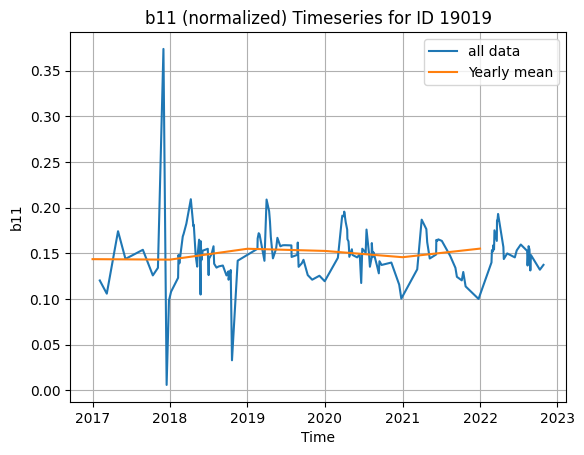

In [ ]:
plot_timeseries_oneid(19019 , col) 

# Approx. the first 40 rows with pred = 1 (sorted by combi_top_features) are mislabeled by the model
# The model tends to predict "disturbed" too often, 
# whereas the first rows with pred = 0 seem to be more accurate.